# Solve cartpole with REINFORCE

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

**2019 update:** Changes have been made to the display of environments due to the previous `viewer` being incompatible with newer versions of Gym.

**2022 update:** Rendering was disabled, and the notebook now uses the `colabgymrender` package to render a video.

In this part, we will create an agent that can learn to solve the [cartpole problem](https://gym.openai.com/envs/CartPole-v0/) from OpenAI Gym by applying a simple policy gradient method called REINFORCE.
In the cartpole problem, we need to balance a pole on a cart that moves along a track by applying left and right forces to the cart.

We will implement a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

The policy is a neural network with parameters $\theta$ that can be trained with gradient descent.
When the set of available actions is discrete, we can use a network with softmax output do describe the distribution.
The core idea of training the policy network is quite simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*.

To achieve this, we apply the gradient of the expected discounted total reward (return):

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta(a|s) R({a}) \, da \\
&= \int \nabla_\theta p_\theta(a|s) R(a)  \, da \\
&= \int p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) R(a) \, da \\
&= \mathbb{E}[\nabla_\theta \log p_\theta(a|s) R(a)]
\end{align}
$$

by definition of expectation and using the identity

$$
\nabla_\theta p_\theta(a|s) = p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) \ .
$$

The expectation cannot be evaluated analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return a sequence of *actions*, *states* and *rewards*. This allows us to replace the integral with a Monte Carlo average:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) R_t \ ,
$$

which is our final gradient estimator, also known as REINFORCE. In the Monte Carlo estimator we run the environment simulator for a predefined number of steps with actions chosen stochastically according to the current stochastic action network $p_\theta(a|s)$.

*Note: For simple reinforcement learning problems (like the one we will address in this exercise) there are simpler methods that work just fine. However, the Policy Gradient method (with some extensions) has been shown to also work well for complex problems with high dimensional inputs and many parameters, where simple methods become inadequate.*

## Policy gradient

In [1]:
# Install colabgymrender to display gym environments in Colab
!pip install gym[classic_control] > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender > /dev/null 2>&1
!pip install imageio==2.4.1 > /dev/null 2>&1

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from gym import wrappers
from colabgymrender.recorder import Recorder

  from scipy.ndimage.filters import sobel



First we create the environment:

In [3]:
env = gym.make('CartPole-v0') # Create environment


  and should_run_async(code)

  logger.warn(

  deprecation(

  deprecation(



A state in this environment is four numbers describing the position and speed of the cart along with the angle and angular speed of the pole.

There are two available actions: push the cart *left* or *right* encoded as 0 and 1.

In [4]:
s = env.reset()
a = env.action_space.sample()
print('sample state:', s)
print('sample action:', a )

sample state: [ 0.02294176 -0.04872015  0.03284828  0.00583829]
sample action: 1


Let us see how the environment looks when we just take random actions. Note that the episode ends when the pole either 1) is more than 15 degrees from vertical, 2) more outside of the frame or 3) the pole is successfully balanced for some fixed duration.

In [5]:
env = gym.make('CartPole-v0') # Create environment
env = Recorder(env, "./video") # To display environment in Colab
env.reset() # Reset environment

# Run environment
while True:
    action = env.action_space.sample() # Get a random action
    _, _, done, _ = env.step(action) # Take a step
    if done: break # Break if environment is done

env.close() # Close environment
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



TypeError: ignored

Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

Let's first define our network and helper functions.

In [11]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_hidden1, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden = nn.Linear(n_inputs, n_hidden)
        self.hidden1 = nn.Linear(n_hidden, n_hidden1)
        self.out = nn.Linear(n_hidden1, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.out(x)
        return F.softmax(x, dim=1)

    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

  and should_run_async(code)



In [12]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [13]:
n_inputs = env.observation_space.shape[0]
n_hidden = 16
n_hidden1 = 24
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

state shape: 4
action shape: 2


In [14]:
# training settings

num_episodes = 400
rollout_limit = 500 # max rollout length
discount_factor = 0.9 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.005 # you know this by now
val_freq = 100 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_hidden1, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s = env.reset()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()
            s1, r, done, _ = env.step(a)
            rollout.append((s, a, r))
            s = s1
            if done: break
        # prepare batch
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0])
        actions = np.vstack(rollout[:,1])
        rewards = np.array(rollout[:,2], dtype=float)
        returns = compute_returns(rewards, discount_factor)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                        a = a_prob.argmax().item()
                    s, r, done, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



start training


  rollout = np.array(rollout)



 100. mean training reward:  14.16, mean validation reward:   9.10, mean loss:  2.6538
 200. mean training reward:  11.83, mean validation reward:   8.80, mean loss:  2.0120
 300. mean training reward:  14.04, mean validation reward:   9.10, mean loss:  2.8107
 400. mean training reward:  10.76, mean validation reward:   9.40, mean loss:  1.4821
done


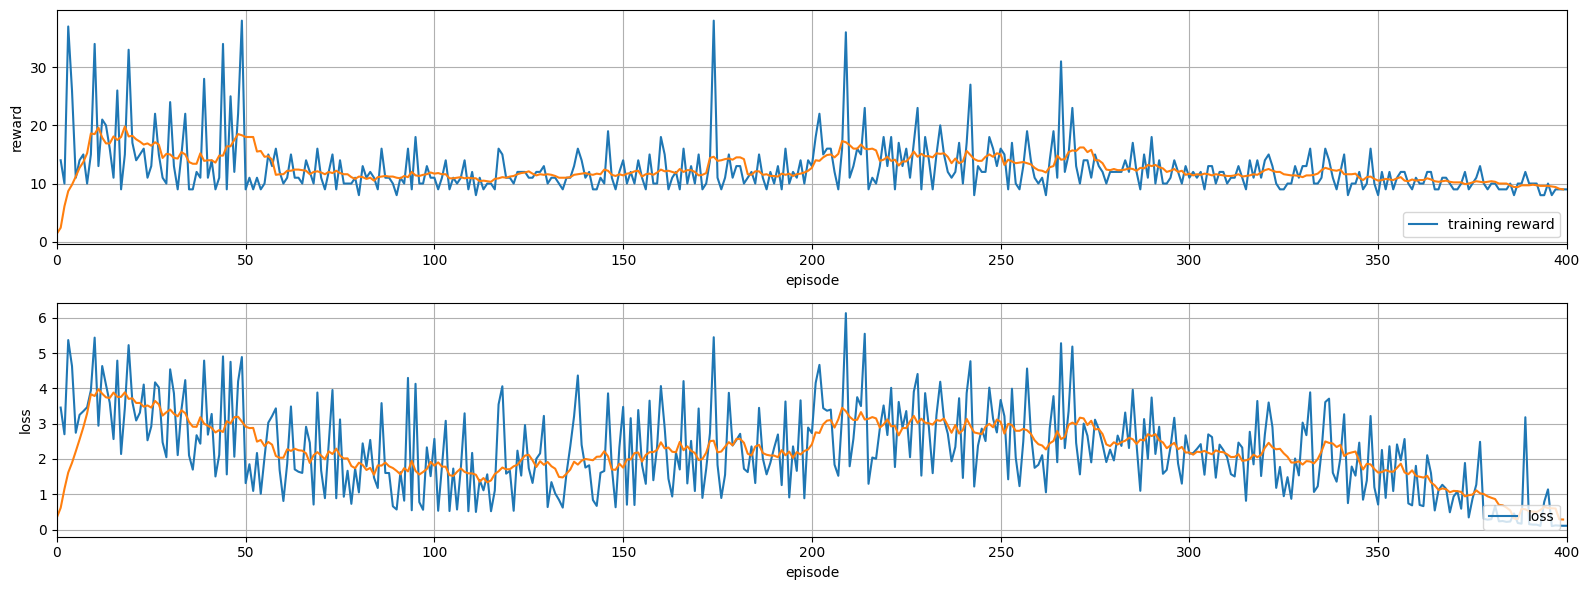

In [15]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

Now let's review the solution!

In [16]:
env = Recorder(env, "./gym-results") # wrappers.Monitor(env, "./gym-results", force=True) # Create wrapper to display environment
s = env.reset()

for _ in range(500):
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _ = env.step(a)
    if done: break

# env.close()
env.play()

  deprecation(



TypeError: ignored

## Reducing variance

By default, this gradient estimator has high variance and therefore variance reduction becomes important to learn more complex tasks.
We can reduce variance by subtracting a baseline from the returns, which is unbiased in expectation:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) (R_t-b_t) \ ,
$$

where the baseline, $b_t$, is estimated by the return a timestep $t$ averaged over $V$ rollouts.

$$
b_t = \frac{1}{V} \sum_{v=1}^V R_t^{(v)} \ .
$$

## Exercises

Now it is your turn! Make sure you read and understand the code, then play around with it and try to make it learn better and faster.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* network layers


### Exercise 1

*Describe any changes you made to the code and why you think they improve the agent. Are you able to get solutions consistently?*

**Answer:**

Decreasing the discount factor by a lot does not really improve the agent. It made the training faster since the agent becomes more focused on long term maximization rather than being accurate in the future. However, the results were worse.
When we increase the number of episode, the training task becomes longer but the results are higher.
Increasing the learning rate made our network converge faster.
Increasing the number of layers also improved our network, with an additional computaitnoal cost.

### Exercise 2

*Consider the following sequence of rewards produced by an agent interacting with an environment for 10 timesteps:*

[0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

* *What is the total reward?*
* *What is the total future reward in each timestep?*
* *What is the discounted future reward in each timestep if $\gamma = 0.9$?*

*Hint: See introdution notebook.*

**Answer:**

- Since the total reward can be expressed as : $\sum^\tau_{t\in \tau}r_t$, we get that the total reward is equal to 5
- Our total reward is equal to 5. Whenever the agent gets a reward, we decrease a unit from this total reward. Therefore:

  * $R_1 = 5$
  * $R_2 = 5$
  * $R_3 = 4$
  * $R_4 = 3$
  * $R_5 = 2$
  * $R_6 = 2$
  * $R_7 = 1$
  * $R_8 = 0$
  * $R_9 = 0$
  * $R_{10} = 0$

- If $\gamma = 0.9$, then:

  * $R_1 \approx 3.2$
  * $R_2 \approx 3.2$
  * $R_3 \approx 2.4$
  * $R_4 \approx 1.7$
  * $R_5 \approx 1.0$
  * $R_6 \approx 1.0$
  * $R_7 \approx 0.5$
  * $R_8 = 0$
  * $R_9 = 0$
  * $R_{10} = 0$


### Exercise 3

*In the training output, you will sometimes observe the validation reward starts out lower than the training reward but as training progresses they cross over and the validation reward becomes higher than the training reward. How can you explain this behavior?*

*Hint: Do we use the policy network in the same way during training and validation?*

**Answer:**

This phenomena results from the exploration vs. exploitation dilemma. When we train the network, we take a sample from the probability distribution of the policy, which presents the possibility of selecting less rewarding behaviors. When validating, on the other hand, we choose an exploitation method, which means that the action with the biggest reward is chosen. when a result, when we develop our policy, it is likely that the behaviors with the highest probability will produce a higher reward, whereas there is greater uncertainty at the start.

### Exercise 4

*How does the policy gradient method we have used address the exploration-exploitation dilemma?*

*Hint: See the introduction notebook about exploration-exploitation.*

**Answer:**

This policy gradient approach easily addresses the exploration-exploitation dilemma by sampling the distribution from the resulting stochastic policy. The policy's distribution is initially produced at random, resulting in poor outcomes and a highly exploratory approach. However, as the policy improves through gradient ascent and the probabilities are learned with greater confidence, the agent automatically switches from an exploratory to an exploitation approach. This effect also translates directly to lengthier training timeframes in subsequent episodes, because a better trained policy is more exploitative and, in this case, requires longer to complete the rollout.

### Exercise 5 [optional]

Extend the code above to reduce variance of the gradient estimator by computing and subtracting the baseline estimate.

*Hint: You need to sample a batch of rollouts (now we sample just one) for each update in order to compute the baseline, $b_t$.*